In [456]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import imageio
import os
from finite_volume.advection import AdvectionSolver
from finite_volume.initial_conditions import generate_ic


def l1(x: np.ndarray) -> float:
    return np.mean(np.abs(x))


def l2(x: np.ndarray) -> float:
    return np.sqrt(np.mean(np.square(x)))


def linf(x: np.ndarray) -> float:
    return np.max(np.abs(x))

In [457]:
p = 1
a = 1
k = 1e-15
ic_type__PAD = "square", (-np.inf, np.inf)
quadrature = "transverse"
SED = False
limiter_config = {
    "aposteriori_limiting": True,
    "convex": False,
    "fallback_limiter": "moncen",
    "fallback_to_first_order": False,
    "hancock": False,
    "cause_trouble": True,
    "mpp_tolerance": 0.,
    "NAD": None,
}

In [458]:
ic_type, PAD = ic_type__PAD


def linear_transformation(x):
    return a * x + k


def inverse_linear_transformation(x):
    return (1 / a) * (x - k)


def u0(x, y):
    return generate_ic(type=ic_type, x=x, y=y)


def u0_shifted(x, y):
    out = linear_transformation(u0(x, y))
    # out[2, 2] = out[2, 2] + 1e-15
    return out


u0_shifted.__name__ += f"_{a}_{k}"

shared_config = dict(
    **limiter_config,
    save=False,
    load=False,
    v=(1, 1),
    n=(64,),
    order=p + 1,
    courant=0.59,
    snapshot_dt=1,
    num_snapshots=1,
    flux_strategy=quadrature,
    SED=SED,
)

# baseline
solver = AdvectionSolver(
    **shared_config,
    u0=u0,
    PAD=PAD,
)
solver.ssprk2()

# shifted initial condition
translated_solver = AdvectionSolver(
    **shared_config,
    u0=u0_shifted,
    PAD=sorted((linear_transformation(PAD[0]), linear_transformation(PAD[1]))),
)
translated_solver.ssprk2()

# check equivariance
diffs = (
    linear_transformation(solver.u_snapshots[-1][1])
    - translated_solver.u_snapshots[-1][1]
)
print(f"{l1(diffs)=}")
print(f"{l2(diffs)=}")
print(f"{linf(diffs)=}")

New solution instance...


100%|██████████| 1.0/1 [00:00]                 



New solution instance...


100%|██████████| 1.0/1 [00:00]                 



l1(diffs)=1.6306631823697105e-07
l2(diffs)=1.2925338291557921e-06
linf(diffs)=2.3486215845358593e-05


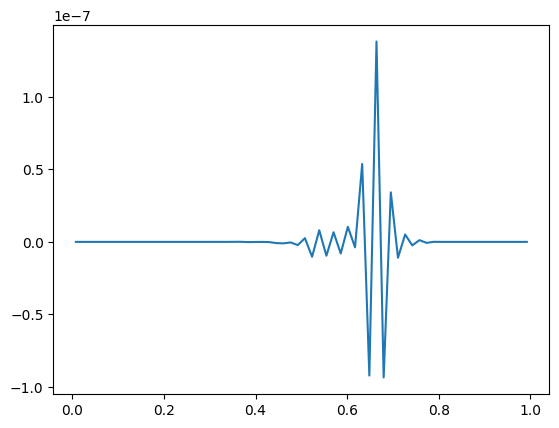

In [459]:
i = -1
j = 48

plt.plot(solver.x, inverse_linear_transformation(translated_solver.u_snapshots[i][1][j, :]) - solver.u_snapshots[i][1][j, :])

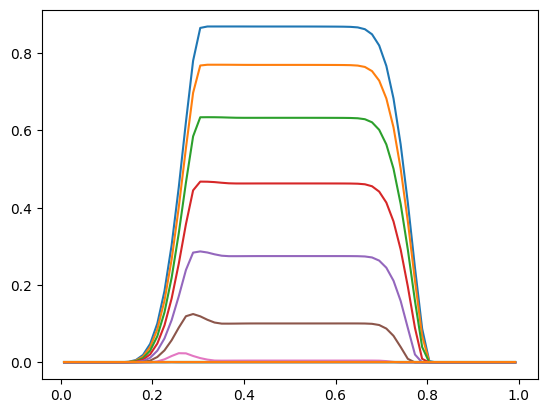

In [460]:
i = -1
j = 55

for j in range(45, 57):
    plt.plot(solver.x, solver.u_snapshots[i][1][j, :])

# plt.plot(solver.x, inverse_linear_transformation(translated_solver.u_snapshots[i][1][j, :]))

-2.2737367544323206e-13


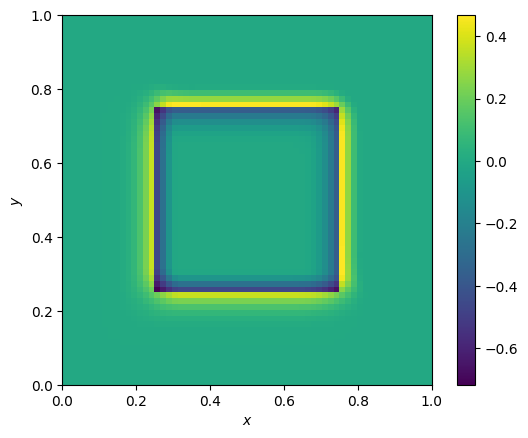

In [461]:
plt.imshow(
    np.flipud(
        inverse_linear_transformation(
            translated_solver.u_snapshots[-1][1] - translated_solver.u_snapshots[0][1]
        )
    ),
    extent=(0, 1, 0, 1),
)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar()

print(
    np.sum(translated_solver.u_snapshots[-1][1])
    - np.sum(translated_solver.u_snapshots[0][1])
)

0.0


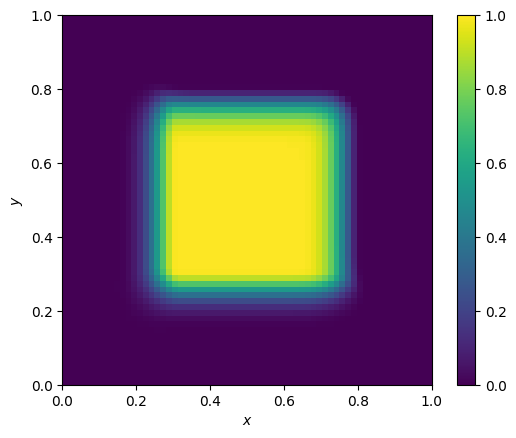

In [462]:
plt.imshow(
    np.flipud(solver.u_snapshots[-1][1]), extent=(0, 1, 0, 1)
)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar()

print(np.sum(solver.u_snapshots[-1][1]) - np.sum(solver.u_snapshots[0][1]))

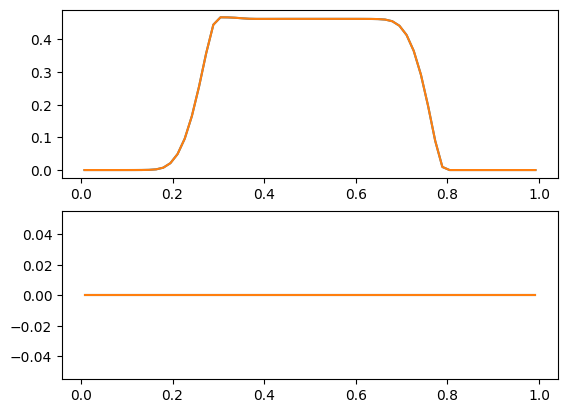

In [463]:
fig, axs = plt.subplots(2, 1)

i = -1
j = 48


axs[0].plot(solver.x, solver.u_snapshots[i][1][j, :])
axs[0].plot(
    translated_solver.x,
    inverse_linear_transformation(translated_solver.u_snapshots[i][1][j, :]),
)

axs[1].plot(solver.x, solver.theta_snapshots[i][1][j, :])
axs[1].plot(translated_solver.x, translated_solver.theta_snapshots[i][1][j, :])

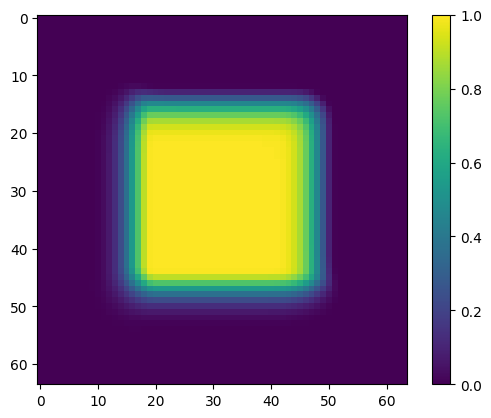

In [464]:
plt.imshow(np.flipud(solver.u_snapshots[i][1]))
plt.colorbar()

In [465]:
print(solver.compute_violations()[1]["worst"])
print(translated_solver.compute_violations()[1]["worst"])

inf
inf


Text(0, 0.5, '$y$')

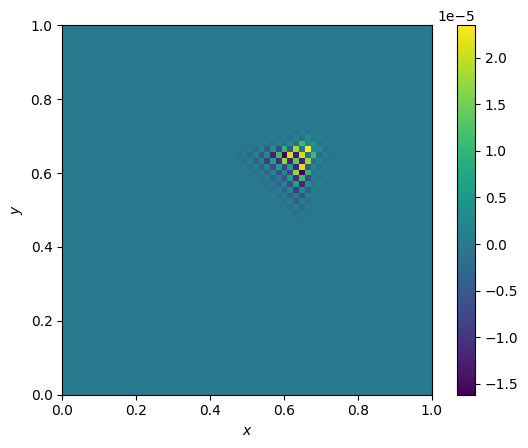

In [466]:
i = -1

plt.imshow(
    np.flipud(
        translated_solver.u_snapshots[i][1]
        - linear_transformation(solver.u_snapshots[i][1])
    ),
    extent=(0, 1, 0, 1),
)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")

In [467]:
# generate frames
for i, ((t, u1), (_, u2)) in enumerate(
    zip(solver.u_snapshots, translated_solver.u_snapshots)
):
    plt.imshow(
        np.flipud(inverse_linear_transformation(u2) - u1),
        extent=(0, 1, 0, 1),
    )
    plt.colorbar()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.savefig(f"frames/{i:04d}.png", dpi=100)
    plt.clf()

In [468]:
# Directory containing PNG files
png_directory = "frames/"

# Output GIF filename
output_gif_filename = "gifs/output.gif"

# List all PNG files in the directory
png_files = [file for file in os.listdir(png_directory) if file.endswith(".png")]
png_files.sort()  # Ensure files are sorted in the correct order

# Create a list to store the images
images = []

# Read each PNG file and append it to the images list
for png_file in png_files:
    file_path = os.path.join(png_directory, png_file)
    images.append(imageio.imread(file_path))

# Save the images as a GIF
imageio.mimsave(output_gif_filename, images, duration=0.5)  # Adjust duration as needed

print(f"GIF generated successfully: {output_gif_filename}")